In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # comment this line if you don't want to use seaborn for plots

import numpy as np
from scipy import stats

# add the path to the abcTau package
import sys
#sys.path.append('./abcTau')
sys.path.append('C:\\Users\\ipochino\\.conda\\envs\\isttc\\Lib\\site-packages\\abcTau') # IP: replaced previous line with that; relative path was not working
import abcTau

### Generating single timescale spiking data

In [2]:
abc_tau_folder = 'D:\\intr_timescales\\abcTau-master\\'
dataload_path = abc_tau_folder + 'example_data/'
isttc_results_folder_path = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\'

In [ ]:
# load data time-series as a numpy array (numTrials * time-points)
filename = 'OU_tau100_T1000_fs1000_trials500'
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the dispersion parameter if computed with grid-search
maxTimeLag = 50 # only used when using autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)

In [ ]:
data_load.shape

In [ ]:
sns.heatmap(data_load) # is it z-scored binned data?

In [ ]:
print('data_sumStat {}, data_mean {}, data_var {}, T {}, numTrials {}'.format(data_sumStat, data_mean, data_var, T, numTrials))

In [ ]:
gt_tau = 100 # ground-truth timescale

# fit 
popt, poptcov = abcTau.preprocessing.fit_oneTauExponential(data_sumStat, binSize, maxTimeLag)
tau = popt[1]

# check if estimated timescales with exponential fit are biased or not
theta = np.array([tau])

In [ ]:
theta = np.array([20])
generativeModel = 'oneTauOU'
syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                             '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
sns.heatmap(syn_data) # is it z-scored binned data?

In [ ]:
theta = np.array([150])
generativeModel = 'oneTauOU'
syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                             '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
sns.heatmap(syn_data) # is it z-scored binned data?

In [ ]:
syn_data_ = np.random.poisson(syn_data)

In [ ]:
theta = np.array([20])
generativeModel = 'oneTauOU_poissonSpikes'
syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                             '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
sns.heatmap(syn_data) 

In [ ]:
theta = np.array([150])
#disp=1
generativeModel = 'oneTauOU_poissonSpikes'
syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                             '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
sns.heatmap(syn_data) 

### Tests

In [3]:
def OU_gen(tau, D, deltaT, T, numTrials):
    """Generate an OU process with a single timescale, zero mean and unit variance.

    Parameters
    -----------
    tau : float
        timescale.
    D : float
        diffusion parameter.
    deltaT : float
        temporal resolution for the OU process generation.    
    T : float
        duration of trials.
    numTrials : float
        number of trials.
    
    
    Returns
    -------
    ou : nd array
        array of generated OU process (numTrials * (T/deltaT)).
    """
    
    numBin = int(T/deltaT)
    noise =  np.random.normal(loc=0,scale=1, size=(numTrials,numBin))
    ou = np.zeros((numTrials,numBin))
    ou[:,0] = noise[:,0]
    for iBin in range(1,numBin):
        ou[:,iBin]  = ou[:,iBin-1] - (ou[:,iBin-1]/tau) * deltaT + np.sqrt(2*D*deltaT) * noise[:,iBin-1]
        
    return ou

def binData(data, new_shape):
    """bin time-series.

    Parameters
    -----------
    data : nd array
        time-series (numTrials * time-points).
    new_shape : 1d array
        [numTrials, numBin]
    
    Returns
    -------
    binned_data : nd array
        binned time-series (numTrials * numBin).
    """
    
    shape = (new_shape[0], data.shape[0] // new_shape[0],
             new_shape[1], data.shape[1] // new_shape[1])
    binned_data = data.reshape(shape).sum(-1).sum(1)
    return binned_data

In [4]:
theta = np.array([200])
data_mean = 1
data_var = 2.1
binSize = 50
deltaT = 1
numTrials = 500
T = 1000*5 # ms

In [5]:
# load params
tau = np.array(theta[0])    

# setting the params of OU
v = 1
D = v/tau

ou_std =  np.sqrt(data_var - data_mean)/deltaT# law of total variance  
ou_mean = data_mean/deltaT # law of total expectation
binsData =  np.arange(0, T + binSize, binSize)
numBinData = len(binsData)-1

# generate OU
ou_all = OU_gen(tau, D, deltaT, T, numTrials)

#ou_check = np.max(ou_all)
#if not np.isfinite(ou_check) or ou_check>10**10: # check for all-nan values
#    return np.zeros((numTrials,numBinData)), numBinData

# fit mean and var
ou_all = ou_std * ou_all + ou_mean
ou_all[ou_all < 0] = 0

In [ ]:
ou_all.shape

In [ ]:
sns.heatmap(ou_all) 

In [ ]:
rate_sum_binned = binData(ou_all, [numTrials,numBinData]) * deltaT
print(rate_sum_binned.shape)
sns.heatmap(rate_sum_binned) 

In [ ]:
syn_data_spike_count = np.random.poisson(ou_all)
sns.heatmap(syn_data_spike_count) 

In [ ]:
syn_data_binned_spike_count = np.random.poisson(rate_sum_binned)
sns.heatmap(syn_data_binned_spike_count) 

In [6]:
ou_all_not_binned = ou_all
ou_all_not_binned.shape

(500, 5000)

In [9]:
spikeTrain = np.zeros(ou_all_not_binned.shape)
spikeTrain.shape

(500, 5000)

In [11]:
for i in range(ou_all_not_binned.shape[0]):
    spikeTrain[i,:] = [1 if ou_all_not_binned[i,j] > np.random.random() else 0 for j in range(ou_all_not_binned.shape[1])]

<Axes: >

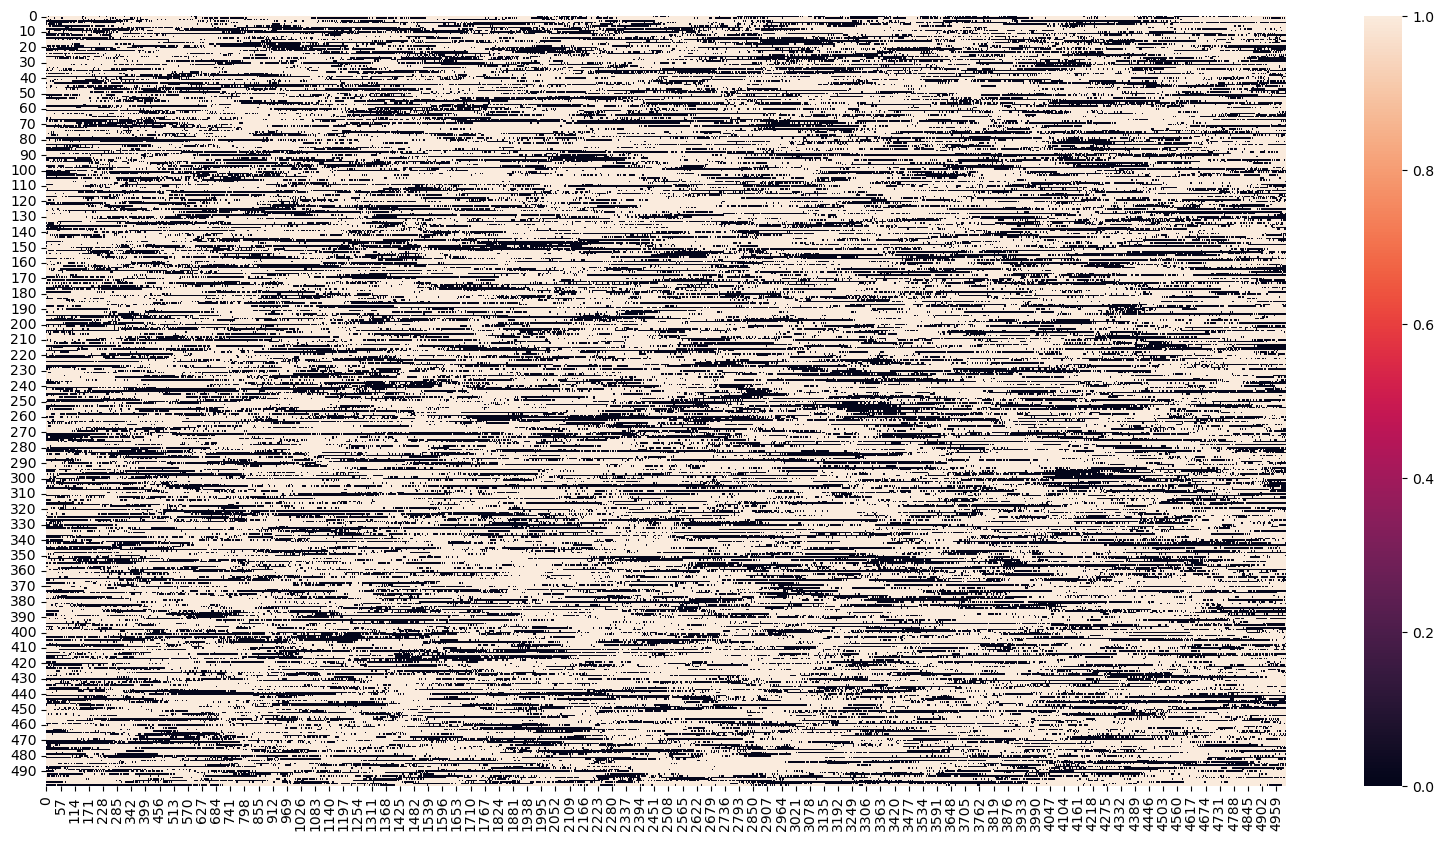

In [12]:
fig, axes = plt.subplots(1,1, figsize=(20,10))

sns.heatmap(ax=axes, data=spikeTrain[:,:]) 

In [13]:
# save spiketrain 
spikeTrain.shape
np.save(isttc_results_folder_path + 'dataset\\spike_train_tau200ms_500trials_5000ms.npy', spikeTrain)

(500, 100)


<Axes: >

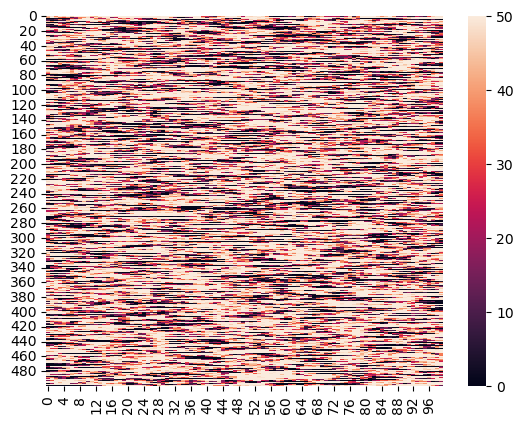

In [14]:
# bin the spike train
spike_train_binned = binData(spikeTrain, [numTrials,numBinData]) * deltaT
print(spike_train_binned.shape)
sns.heatmap(spike_train_binned) 

In [15]:
# calculate taus on that 
# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the dispersion parameter if computed with grid-search
maxTimeLag = 500 # only used when using autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(spikeTrain, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)

In [12]:
data_sumStat

array([ 1.00000000e+00,  7.25518589e-01,  7.11122180e-01,  6.98112604e-01,
        6.84725172e-01,  6.71772635e-01,  6.59722234e-01,  6.48524498e-01,
        6.37930963e-01,  6.27183606e-01,  6.15975071e-01,  6.06167924e-01,
        5.96775307e-01,  5.87816182e-01,  5.78640023e-01,  5.69843003e-01,
        5.61671721e-01,  5.52755385e-01,  5.44541546e-01,  5.36564461e-01,
        5.28608858e-01,  5.21167794e-01,  5.13315128e-01,  5.06293953e-01,
        4.99112351e-01,  4.91862900e-01,  4.85210045e-01,  4.78257324e-01,
        4.71959417e-01,  4.65460216e-01,  4.59446903e-01,  4.53105475e-01,
        4.46897698e-01,  4.41196758e-01,  4.35687803e-01,  4.29894312e-01,
        4.24436812e-01,  4.18966297e-01,  4.13400852e-01,  4.08002289e-01,
        4.02453141e-01,  3.97100726e-01,  3.91933712e-01,  3.87420276e-01,
        3.82323536e-01,  3.77373404e-01,  3.72809305e-01,  3.67903362e-01,
        3.63380928e-01,  3.59060446e-01,  3.54020207e-01,  3.49918994e-01,
        3.45412771e-01,  

In [16]:
# fit 
popt, poptcov = abcTau.preprocessing.fit_oneTauExponential(data_sumStat, binSize, maxTimeLag)
tau = popt[1]
print(tau)

135.70254773603313


In [ ]:
from statsmodels.tsa.stattools import acf
acf_ = acf(spike_train_binned, nlags=20)

In [ ]:
def func_exp(x, a, b, c):
    """
    Exponential function to fit the data.
    :param x: 1d array, independent variable
    :param a: float, parameter to fit
    :param b: float, parameter to fit
    :param c: float, parameter to fit
    :return: callable
    """
    return a * np.exp(-b * x) + c
popt, pcov = curve_fit(func_exp, np.linspace(0,20,20), v['acf'][start_idx_:], maxfev=5000)